# Long-run performance

In [3]:
import torch
import numpy as np
import scipy.stats
import lp_wealth
from sim_helpers import *
from notebook_helpers import *
from matplotlib.pyplot import figure

In [2]:
num_samples = 1000

sigma = torch.tensor(1.6)
mu = torch.tensor(1.)
gamma = torch.ones(num_samples) * .9

time_step = torch.min(get_max_time_step(gamma, sigma, mu))
num_steps = max(get_min_time_steps(sigma, gamma, time_step), 300000)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)

checkpoints = sim_loop(sim, num_steps, num_checkpoints = num_steps/100)

time = np.array([torch.mean(checkpoint.time) for checkpoint in checkpoints])
amm_wealth = np.array([torch.mean(checkpoint.wealth) for checkpoint in checkpoints])
hodl_wealth = np.array([torch.mean(checkpoint.market_price) for checkpoint in checkpoints])



1 0.0013570785522460938
30001 17.157305240631104
60001 16.971664905548096
90001 17.240777492523193
120001 17.21841788291931
150001 16.42042899131775
180001 16.66607141494751
210001 16.93332028388977
240001 17.018114805221558
270001 17.023560285568237


Text(0.5, 1.0, 'Mean wealth for HODL vs. Uniswap LP ($\\mu$ = 1.0, $\\sigma$ = 1.6)')

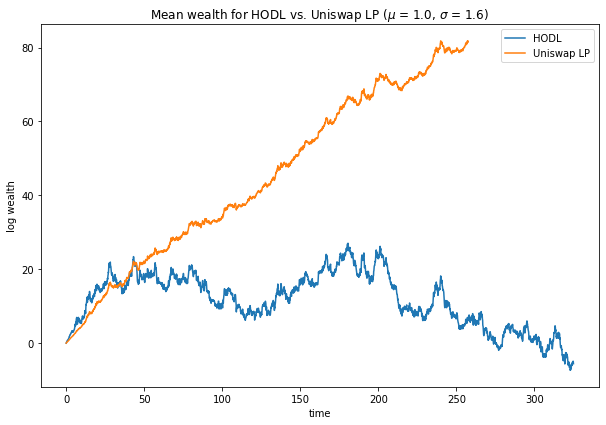

In [3]:
from matplotlib.pyplot import figure
width=10
figure(figsize=(width,width/1.5))
sbn.lineplot(time, np.log(hodl_wealth), label="HODL")
sbn.lineplot(time, np.log(amm_wealth), label="Uniswap LP")
plt.xlabel("time")
plt.ylabel("log wealth")
plt.title(f"Mean wealth for HODL vs. Uniswap LP ($\mu$ = {float(mu)}, $\sigma$ = {round(float(sigma),2)})")


# Volatility Drag

Text(0.5, 1.0, 'realized wealth vs. expected value in the presence of volatility')

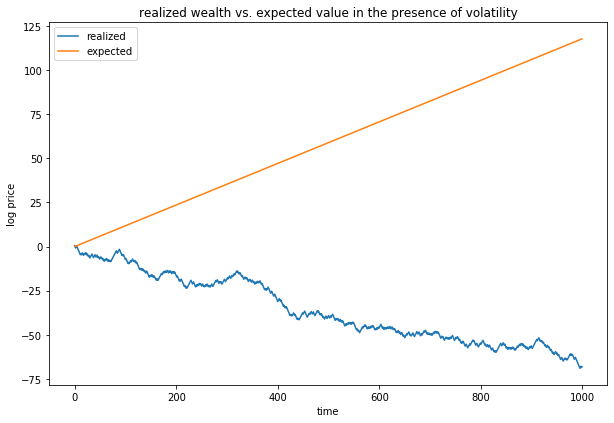

In [4]:
num_steps = 1000
flips = torch.bernoulli(torch.ones(num_steps)*.5)
returns = torch.where(flips==0, torch.tensor(.5), torch.tensor(1.75))
value = torch.cumprod(returns,0)

width=10
figure(figsize=(width,width/1.5))
sbn.lineplot(range(num_steps), np.log(value),label="realized")
sbn.lineplot(range(num_steps), np.log(1.125**np.arange(num_steps)),label="expected")
plt.xlabel("time")
plt.ylabel("log price")
plt.title(f"realized wealth vs. expected value in the presence of volatility")



# Fee discontinuity

Text(0.5, 1.0, 'wealth growth rate vs. fee ($\\mu$ = 1.0, $\\sigma$ = 1.2)')

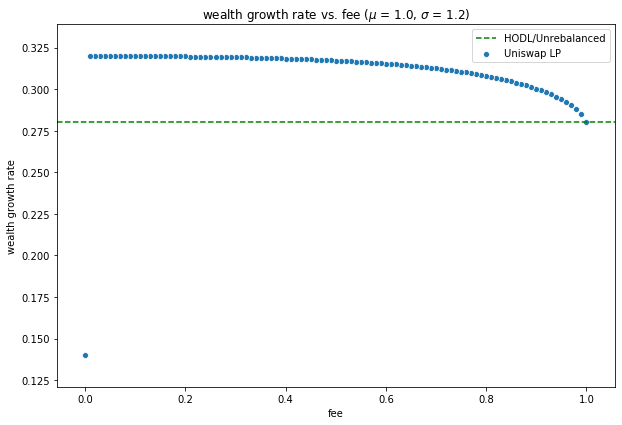

In [9]:
num_samples = 1000

sigma = torch.tensor(1.2)
mu = torch.tensor(1.)
gamma = torch.arange(0., 101, 1)/100

time_step = torch.tensor(1.)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)
growth = sim.predict_wealth_growth_rate()

width=10
figure(figsize=(width,width/1.5))
ax = sbn.scatterplot(1-gamma, growth, label='Uniswap LP')
ax.axhline(mu - sigma**2/2, label="HODL/Unrebalanced", color='g', ls='--')
ax.legend()
plt.xlabel("fee")
plt.ylabel("wealth growth rate")
plt.title(f"wealth growth rate vs. fee ($\mu$ = {float(mu)}, $\sigma$ = {round(float(sigma),2)})")

# Prediction Validation

50524
1 0.0006830692291259766
5053 2.968566656112671
10105 2.9633848667144775
15157 2.9453115463256836
20209 2.948908567428589
25261 2.951866626739502
30313 2.968806743621826
35365 2.9574623107910156
40417 2.956833839416504
45469 2.951338052749634
50521 2.956695079803467


[Text(0, 0.5, 'G'),
 Text(0.5, 0, 'pred'),
 Text(0.5, 1.0, 'predicted wealth growth vs. actual')]

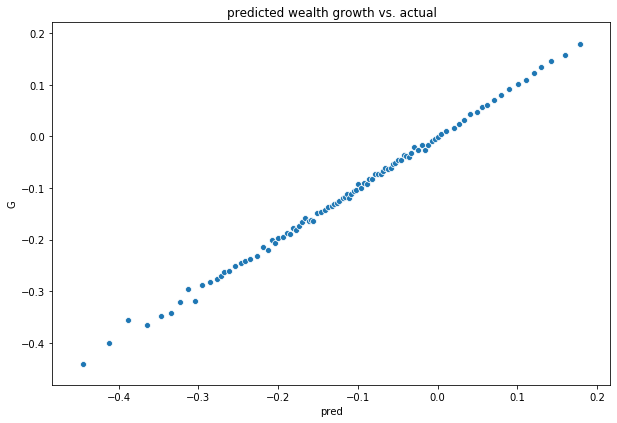

In [6]:
num_samples = 1000

mu = (torch.rand(num_samples) - .5)
sigma = torch.rand(num_samples) + .5
gamma = torch.rand(num_samples) * .8 + .1

time_step = get_max_time_step(gamma, sigma, mu)
num_steps = get_min_time_steps(sigma, gamma, time_step)
print(num_steps)
sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)

sim_loop(sim, num_steps)

d = mu - sigma**2 / 2
predicted_growth = d/2 * ((1 + gamma**(4 * d/sigma**2))/(1 - gamma**(4 * d/sigma**2))*(1-gamma)/(1+gamma)+1)
predicted_growth_negative_d = -d/2 * ((1 + gamma**(-4 * d/sigma**2))/(1 - gamma**(-4 * d/sigma**2))*(1-gamma)/(1+gamma)-1)

width=10
figure(figsize=(width,width/1.5))

ax=bin_plot(predicted_growth_negative_d, sim.compute_wealth_growth_rate())

ax.set(xlabel='pred', ylabel='G',title="predicted wealth growth vs. actual")
